In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class MyLogReg():
    
    def __init__(self, n_iter=5000, learning_rate=0.01, weights=None, metric=None, reg=None,
                l1_coef=0, l2_coef=0):
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        self.weights = weights
        self.metric = metric
        self.metric_value = None
        self.reg = reg
        self.l1_coef = l1_coef
        self.l2_coef = l2_coef 
        
    def __str__(self):
        return f'MyLogReg class: n_iter={self.n_iter}, learning_rate={self.learning_rate}'
    
    def fit(self, X, y, verbose=False):
        n = len(X)
        y = np.array(y)
        m = len(X.columns)
        X.insert(0, 'x0', [1] * n)
        self.weights = np.zeros(m + 1)
        eps = 1e-15
        error = []
        for i in range(self.n_iter):
            y_pred = 1 / (1 + np.exp(-np.dot(X, self.weights)))
            LogLoss = -(1 / n) * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)) #  + self.regularization()[0] / n
            grad = (1 / n) * np.dot((y_pred - y), X) # + self.regularization()[1]  / n
            self.weights = self.weights - self.learning_rate * grad
            error.append(LogLoss)
        del X['x0']
        return (self.weights, error)
        
    def get_coef(self):
        return np.sum(self.weights[1:])
    
    def predict_proba(self, X):
        if not(len(self.weights) == len(X.columns)):
            n = len(X)
            X.insert(0, 'x0', [1] * n)
        prb = 1 / (1 + np.exp(-np.dot(X, self.weights)))
        return prb
    
    def predict(self, X):
        if not(len(self.weights) == len(X.columns)):
            n = len(X)
            X.insert(0, 'x0', [1] * n)
        prb = 1 / (1 + np.exp(-np.dot(X, self.weights)))
        y_pred = self.classification(prb, 0.5)
        return int(sum(y_pred))
    
    def metrics(self, y_pred, y):
            TP = np.count_nonzero((y_pred == 1) & (y_pred == y))
            TN = np.count_nonzero((y_pred == 0) & (y_pred == y))
            FN = np.count_nonzero((y_pred == 0) & (y_pred != y))
            FP = np.count_nonzero((y_pred == 1) & (y_pred != y))
            accuracy = (TP + TN) / (TP + TN + FN + FP)
            metrics = {'accuracy': accuracy}
            return metrics[self.metric]
    
    def classification(self, pred):
        classes = np.zeros_like(pred)
        classes[pred >= 0] = 1
        classes[pred < 0] = 0
        return classes
    
    def get_best_score(self):
        return self.metric_value
    
    def regularization(self):
        l1 = self.l1_coef * sum(np.abs(self.weights[1:]))
        l2 = self.l2_coef * sum((self.weights[1:])**2)
        gr1 = np.zeros_like(self.weights)
        gr1[1:] = self.l1_coef * np.sign(self.weights[1:])
        gr2 = np.zeros_like(self.weights)
        gr2[1:] = 2 * self.l2_coef * self.weights[1:]
        regul = {'l1': l1,
                 'l2': l2,
                 'elasticnet': l1 + l2,
                 None: 0}
        regul_grad = {'l1': gr1,
                      'l2': gr2,
                      'elasticnet': gr1 + gr2,
                      None: 0}
        return (regul[self.reg], regul_grad[self.reg])

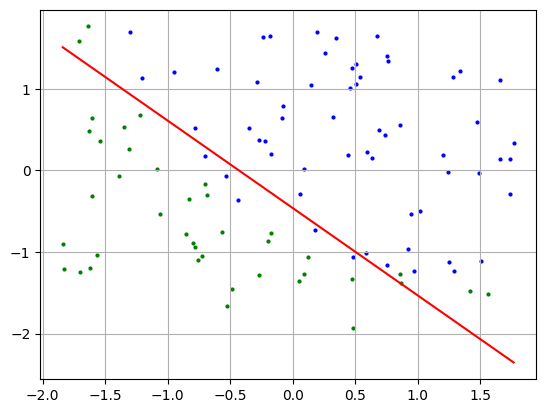

вероятность поступления с 45 и 85 баллами:  0.761168266111083
точность: 0.89
[1.68545283 3.92238686 3.65701519]


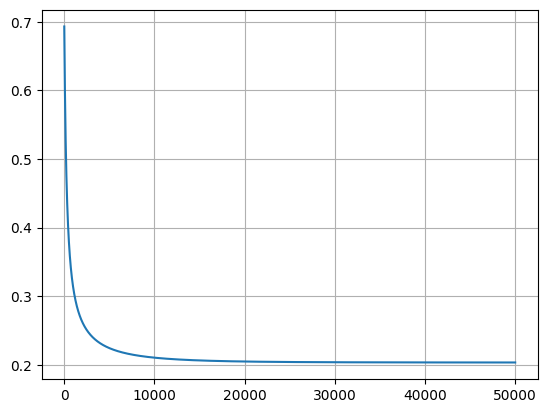

In [9]:
df = pd.read_csv('ex2data1.csv', names=['x1', 'x2', 'y'])
X = df[['x1', 'x2']]
n = len(X)
x1 = np.array(df['x1'])
x2 = np.array(df['x2'])
y = np.array(df['y'])
x1_norm = (x1 - np.mean(x1)) / np.std(x1)                    
x2_norm = (x2 - np.mean(x2)) / np.std(x2)
X_norm = pd.DataFrame({'x1': x1_norm, 'x2': x2_norm, 'y': y})
model = MyLogReg(n_iter=50000, learning_rate=0.01, metric='accuracy')
weights_error = model.fit(X_norm[['x1', 'x2']], y)
weights, error = weights_error[0], weights_error[1]
b = weights[0]
k1 = weights[1]                # x2 = - k1 / k2 - b
k2 = weights[2]
x = np.linspace(min(X_norm['x1']), max(X_norm['x1']), 100)
func = lambda x: - (k1 / k2) * x - b / k2            # построение прямой
plt.scatter(X_norm['x1'].loc[X_norm['y'] == 0], X_norm['x2'].loc[X_norm['y'] == 0], color='g', s=4)
plt.scatter(X_norm['x1'].loc[X_norm['y'] == 1], X_norm['x2'].loc[X_norm['y'] == 1], color='b', s=4)
plt.plot(x, func(x), color='r')
plt.grid(True)
plt.show()
plt.plot(np.arange(len(error)), error)
plt.grid(True)
x1_example = (45 - np.mean(x1)) / np.std(x1)
x2_example = (85 - np.mean(x1)) / np.std(x1)
f = lambda x1, x2: b + x1 * k1 + x2 * k2         # решающее правило
pred = f(x1_norm, x2_norm)                       # выше или ниже прямой
y_pred = model.classification(pred)              # классы
print(f'вероятность поступления с 45 и 85 баллами:  {1 / (1 + np.exp(-np.dot(np.array([1, x1_example, x2_example]), weights)))}')
print(f'точность: {model.metrics(y_pred, y)}')
print(weights)